In [39]:
### test work for everybody
## Install enviroment from Flo
#!module use /work/k20200/k202134/hsm-tools/outtake/module 
#!module add python3/python_3.12-flo
#!install_kernel
#%pip install regionmask

### simple ICON

In [70]:
### 2D variables
import healpy as hp
import numpy as np
import xarray as xr
### nextgems catalog (at least for c3)
import intake
import matplotlib.pyplot as plt
import pandas as pd

import cfgrib
#import xarray as xr # xarray library access and manipulate multi-dimensional data (such as netcdf). With the cfgrib engine we can manipulate grib files
import regionmask # regionmask helps create of geographical regions.
#from matplotlib import pyplot as plt # matplotlib package provides different functions to plot data
import re

In [71]:
def extrapolate_wind_speed(ds, to_height, from_height=None):
    """
    Extrapolate the wind speed from a given height above ground to another.

    If ds already contains a key refering to wind speeds at the desired to_height,
    no conversion is done and the wind speeds are directly returned.

    Extrapolation of the wind speed follows the logarithmic law as desribed in [1].

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the wind speed time-series at 'from_height' with key
        'wnd{height:d}m' and the surface orography with key 'roughness' at the
        geographic locations of the wind speeds.
    from_height : int
        (Optional)
        Height (m) from which the wind speeds are interpolated to 'to_height'.
        If not provided, the closest height to 'to_height' is selected.
    to_height : int|float
        Height (m) to which the wind speeds are extrapolated to.

    Returns
    -------
    da : xarray.DataArray
        DataArray containing the extrapolated wind speeds. Name of the DataArray
        is 'wnd{to_height:d}'.

    References
    ----------
    [1] Equation (2) in Andresen, G. et al (2015): 'Validation of Danish wind
    time series from a new global renewable energy atlas for energy system
    analysis'.

    [2] https://en.wikipedia.org/w/index.php?title=Roughness_length&oldid=862127433,
    Retrieved 2019-02-15.
    """
    # Fast lane
    to_name = "wnd{h:0d}m".format(h=int(to_height))
    if to_name in ds:
        return ds[to_name]

    if from_height is None:
        # Determine closest height to to_name
        heights = np.asarray([int(s[3:-1]) for s in ds if re.match(r"wnd\d+m", s)])

        if len(heights) == 0:
            raise AssertionError("Wind speed is not in dataset")

        from_height = heights[np.argmin(np.abs(heights - to_height))]

    from_name = "wnd{h:0d}m".format(h=int(from_height))

    # Wind speed extrapolation
    wnd_spd = ds[from_name] * (
        np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"])
    )

    wnd_spd.attrs.update(
        {
            "long name": "extrapolated {ht} m wind speed using logarithmic "
            "method with roughness and {hf} m wind speed"
            "".format(ht=to_height, hf=from_height),
            "units": "m s**-1",
        }
    )

    return wnd_spd.rename(to_name)

In [72]:
## Subroutine to get points
def get_nn_lon_lat_index(nside, lons, lats):
    
    lons2, lats2 = np.meshgrid(lons, lats)

    data = xr.DataArray(
        hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lons, lats), nest=True, lonlat=True),
        coords=(("lat", lats), ("lon", lons)),
    )

    return data

#Load data
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

### Select experiment and period
version='ngc4008'
datum0="2020-01-01"
datum="2020-01-31"
#ds = cat.ICON[version](zoom=9,time="PT1D",chunks={}).to_dask() #.['uas','vas'] #PT3H, PT30, P1D
#ds = cat.ICON[version](zoom=9,time="PT15M",chunks={}).to_dask().var.sel(time=slice(datum0, datum))
ds = cat.ICON[version](zoom=9,time="PT15M",chunks={}).to_dask().sel(time=slice(datum0, datum))

#da_healpix[var]#[0,:]
#Definition of your region of interest.
#Definition of your region of interest.
latbox = [27.5, 43.75]
lonbox = [-18.25, 4.5]

#latbox = [-90, 90]
#lonbox = [-180, 179]
dx=0.25#1
dy=0.25#1
#fac=1/dx #10 ~ 10m km, 4 ~ 25 km

loni = np.arange(lonbox[0], lonbox[1]+dx, dx)
lati = np.arange(latbox[0], latbox[1]+dy, dy)
#fac=4 #10 ~ 10m km, 4 ~ 25 km
#loni = np.linspace(lonbox[0], lonbox[1], int((lonbox[1]-lonbox[0])*fac)+1)
#lati = np.linspace(latbox[0], latbox[1], int((latbox[1]-latbox[0])*fac)+1)
#print(lati, len(lati),loni, len(loni))
#loni = np.linspace(lonbox[0], lonbox[1], int((lonbox[1]-lonbox[0])*fac)+1)
#lati = np.linspace(latbox[0], latbox[1], int((latbox[1]-latbox[0])*fac)+1)
#print(lati, loni)

/home/k/k202134/python-envs/py_312/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


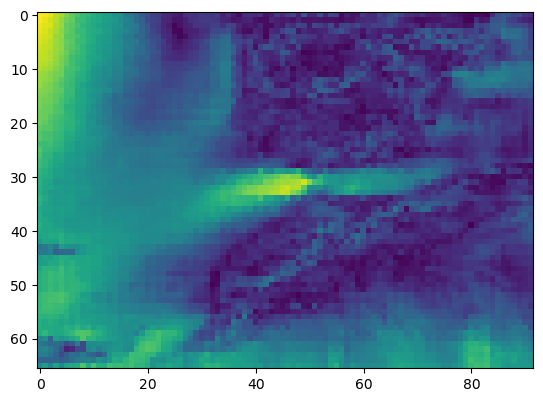

In [63]:
zoom = 7 #zoom 9 = 10km # zoom 7 = 50 km
idx = get_nn_lon_lat_index(ds, loni, lati)

#Variable selection
#var = 'uas'
var= 'sfcwind'
#var2='vas'
#da_healpix = ds[var][0:24,:]
### resemple 1 hour 
da_healpix=ds[var].resample(time="1h").mean()
#da_healpix=ds.resample(time="1h").mean()

#da_healpix = ds[var][0:24,:] #First day


#Regridding
da_lonlat_array = np.reshape(da_healpix.isel(cell=idx).values,newshape=(len(da_healpix.time),len(lati),len(loni)))
#
##Transforming back to Data Array and adding original attributes
coords = {'time': da_healpix.time,
          'latitude': lati,
          'longitude': loni}
dims = ('time', 'latitude', 'longitude')
da_lonlat = xr.DataArray(da_lonlat_array, coords=coords, dims=dims, name=var)
da_lonlat.attrs.update(ds[var].attrs)
###da_lonlat.attrs.update(ds.attrs)

#Too see the results (first time step)
plt.imshow(np.flip(da_lonlat[0,:,:],axis=0))

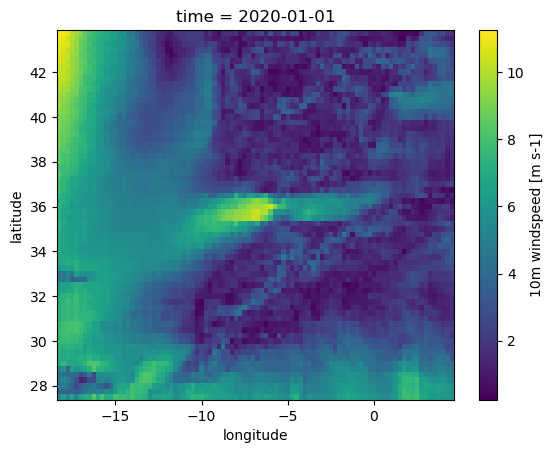

In [93]:
#da_lonlat
d = da_lonlat.to_dataset(name='wnd10m') 
d['wnd10m'][0,...].plot()
#d.ws100.attrs['units'] = 'm s**-1'
#d = d.rename({"lon": "longitude", "lat": "latitude"})
#d['ws100'] 

In [94]:
roughness = xr.open_dataset('/home/b/b382006/tools/impacts/dunkelflaute/atlite/roughness.nc')

roughness = roughness.rename({'fsr':'roughness'})

roughness = roughness.mean(dim='time')

#roughness = _rename_and_clean_coords(roughness)
#roughness.roughness.attrs['prepared_feature'] = 'wind'

### interpolate roughness
da = roughness.roughness.interp_like(d['wnd10m'].isel(time=0))
d=d.assign(roughness=da)
#d
#d['ws10']
### extrapolate wind
to_height=100
wnd=extrapolate_wind_speed(d, to_height)
#wnd[0,...].plot()
#d = da_lonlat.to_dataset(name='wnd10m') 
wnd

<xarray.DataArray 'wnd100m' (time: 744, latitude: 66, longitude: 92)> Size: 36MB
array([[[ 6.53789948,  7.66231331,  6.31619361, ...,  8.31920946,
          8.21496912,  8.10432635],
        [ 4.59434112,  4.48534312,  4.57519557, ...,  8.13420281,
          8.06698658,  7.66100408],
        [ 5.68384599,  5.84197208,  5.42134878, ...,  8.41709639,
          8.18836443,  7.86753875],
        ...,
        [13.27159487, 13.02271009, 12.84454073, ...,  3.49338192,
          3.14527355,  2.29793386],
        [13.56276748, 13.15938414, 12.66348263, ...,  2.64612212,
          2.13517537,  1.72807869],
        [13.64289546, 13.47907433, 13.17450187, ...,  5.47408725,
          3.32173263,  3.24359228]],

       [[ 6.46792274,  7.93821474,  6.26339554, ...,  8.25790298,
          8.13643477,  8.12180974],
        [ 3.12660002,  4.40775765,  3.80441995, ...,  8.21384278,
          8.12282802,  7.91126489],
        [ 5.69585789,  6.02440864,  4.993298  , ...,  8.45161634,
          8.18357725,  8.15446839],
...
        [ 9.54568028,  9.8378312 ,  9.98623517, ...,  5.67625947,
          4.32719495,  4.51283213],
        [ 9.6948417 ,  9.59806934, 10.56907884, ...,  8.50506867,
          7.21238141,  6.23731131],
        [10.89826115, 10.92161325, 11.38355253, ...,  6.346859  ,
          5.7129436 ,  5.53875616]],

       [[ 7.66758969,  9.01078789,  6.38331457, ...,  5.74560652,
          5.67072345,  5.83450981],
        [ 9.64475343,  7.58295388,  8.71921857, ...,  5.0975956 ,
          4.76397248,  4.96826386],
        [11.88144734, 12.37684271, 11.97612118, ...,  4.85248532,
          4.45204097,  5.05915844],
        ...,
        [11.45344891, 10.68837555, 10.63716775, ...,  6.57161181,
          5.14095653,  4.99837612],
        [11.85381729, 11.00479907, 10.5599222 , ...,  9.14737422,
          7.25715419,  6.54984556],
        [11.43459238, 11.39440283, 11.51245128, ...,  6.01902416,
          5.5565231 ,  4.92270259]]])
Coordinates:
  * time       (time) datetime64[ns] 6kB 2020-01-01 ... 2020-01-31T23:00:00
  * latitude   (latitude) float64 528B 27.5 27.75 28.0 ... 43.25 43.5 43.75
  * longitude  (longitude) float64 736B -18.25 -18.0 -17.75 ... 4.0 4.25 4.5
Attributes:
    long name:  extrapolated 100 m wind speed using logarithmic method with r...
    units:      m s**-1

    ws      cf
0  0.0  0  0.0
1  0.5  0  0.0
2  1.0  0  0.0
3  1.5  0  0.0
4  2.0  0  0.0


/tmp/ipykernel_2487274/3655203214.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cv = pd.read_csv('https://raw.githubusercontent.com/hcbloomfield19/UREAD_energy_models_demo_scripts/main/Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')


Text(0, 0.5, 'Capacity factor')

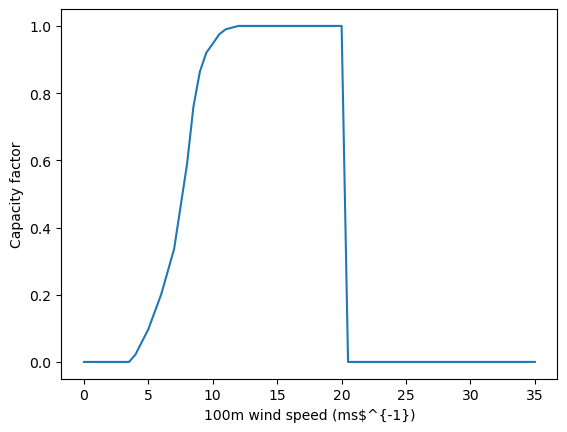

In [89]:
cv = pd.read_csv('https://raw.githubusercontent.com/hcbloomfield19/UREAD_energy_models_demo_scripts/main/Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')
print(cv.head())
plt.plot(cv['ws'],cv['cf'])
plt.xlabel('100m wind speed (ms$^{-1})')
plt.ylabel('Capacity factor')

In [90]:
def convert_to_windpower(wind_speed_data,power_curve_data):
    # convert to an array
    power_curve_w = np.array(power_curve_data['ws'])
    power_curve_p = np.array(power_curve_data['cf'])

    #interpolate to fine resolution.
    pc_winds = np.linspace(0,50,501) # make it finer resolution
    pc_power = np.interp(pc_winds,power_curve_w,power_curve_p)

    reshaped_speed = wind_speed_data.flatten()
    test = np.digitize(reshaped_speed,pc_winds,right=False) # indexing starts
    #from 1 so needs -1: 0 in the next bit to start from the lowest bin.
    test[test ==len(pc_winds)] = 500 # make sure the bins don't go off the
    #end (power is zero by then anyway)
    wind_power_flattened = 0.5*(pc_power[test-1]+pc_power[test])

    wind_power_cf = np.reshape(wind_power_flattened,(np.shape(wind_speed_data)))

    return(wind_power_cf)

In [97]:
d['cf'] = (['time', 'latitude', 'longitude'],  convert_to_windpower(wnd.values, cv) )
d

<xarray.Dataset> Size: 54MB
Dimensions:    (time: 744, latitude: 66, longitude: 92)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2020-01-01 ... 2020-01-31T23:00:00
  * latitude   (latitude) float64 528B 27.5 27.75 28.0 ... 43.25 43.5 43.75
  * longitude  (longitude) float64 736B -18.25 -18.0 -17.75 ... 4.0 4.25 4.5
Data variables:
    wnd10m     (time, latitude, longitude) float32 18MB 5.44 6.374 ... 2.815
    roughness  (latitude, longitude) float64 49kB 0.0001104 0.0001127 ... 0.4619
    cf         (time, latitude, longitude) float64 36MB 0.2758 ... 0.09375

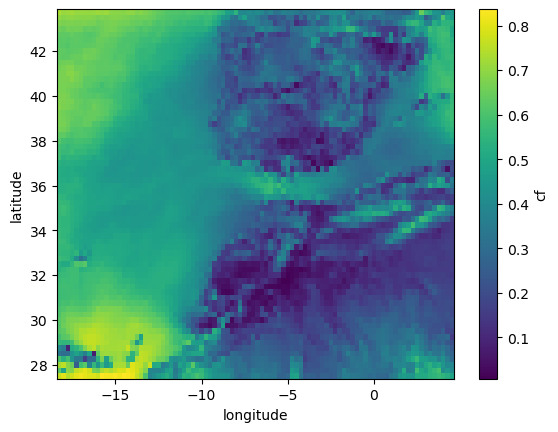

In [98]:
#d['cf'].isel(time=slice(0,48, 8)).plot(x="longitude", y="latitude", col="time", col_wrap=3, cmap=plt.cm.viridis)
d['cf'].mean(axis=0).plot()

In [99]:
# create the cosine weight of latitudes
weigths = np.cos(np.deg2rad(d.latitude))
# create mask of countries based on the data latitude and longitude
countries_masked = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(d, lon_name='longitude', lat_name='latitude')

/home/b/b382006/.local/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


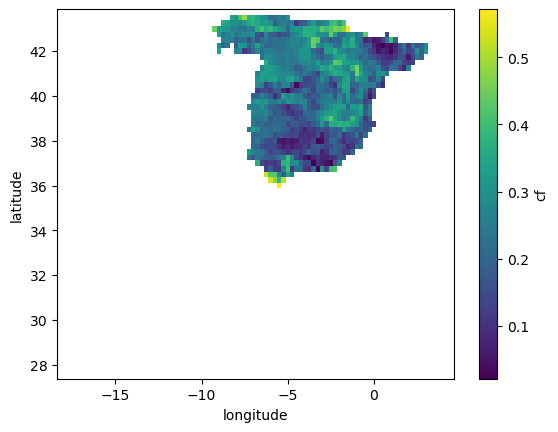

In [105]:
tmp =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(['Spain']))
tmp.mean(axis=0).plot() 

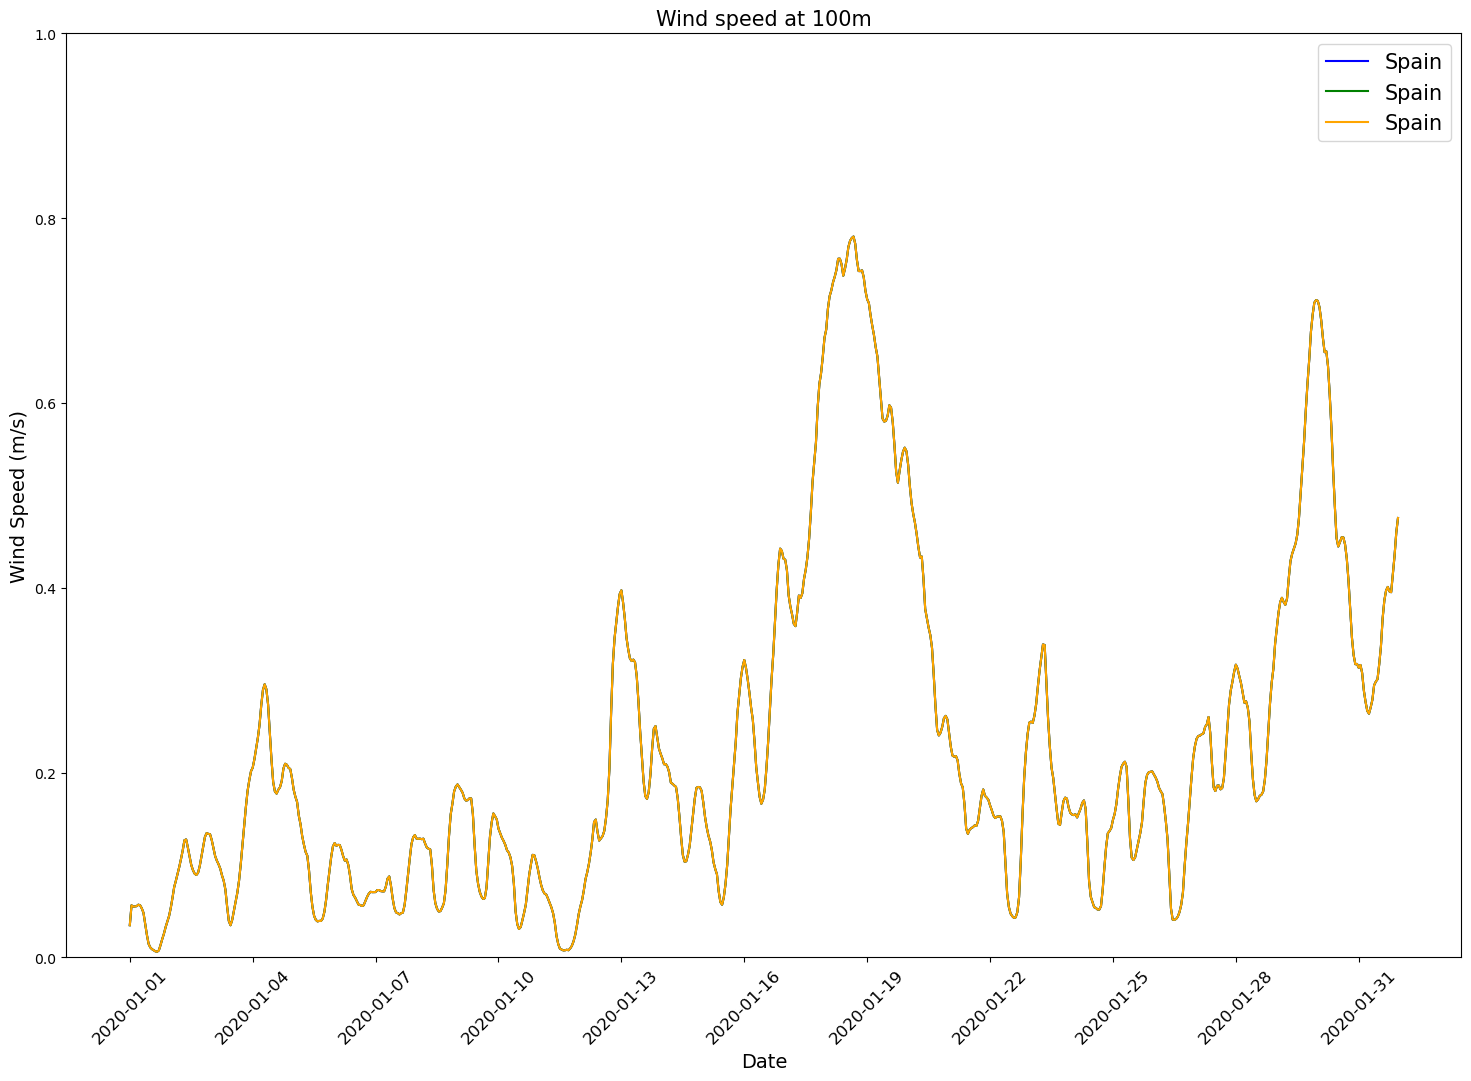

In [101]:
countries_name = ['Spain', 'Spain', 'Spain']
colors = ['blue', 'green', 'orange']

fig, ax = plt.subplots(figsize=(18, 12))
for ii, i in enumerate(countries_name):
    # select different countries
#    ds_country =d['ws100'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
    ds_country =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
    # applied the weighted mean over the country
    wnd100m_country = ds_country.weighted(weigths).mean(dim=('latitude', 'longitude'))
    ax.plot(wnd100m_country, color=colors[ii], label=i)
ax.set_xticks(np.arange(0, len(wnd100m_country.time), 3 * 24))
ax.set_xticklabels(wnd100m_country['time'].values[0: -1: 3 * 24].astype('datetime64[D]'), rotation=45, fontsize=12)
#ax.set_ylim([0, 18])
ax.set_ylim([0, 1])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Wind Speed (m/s)', fontsize=14)
ax.legend(fontsize=15)
plt.title('Wind speed at 100m', fontsize=15)
plt.savefig('wind_speed_100m_countries.png')

### simple IFS

In [5]:
### 2D variables
import healpy as hp
import numpy as np
### nextgems catalog (at least for c3)
import intake
def get_nn_lon_lat_index(nside, lons, lats):
    
    lons2, lats2 = np.meshgrid(lons, lats)
    data = xr.DataArray(hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
                        coords=[("lat", lats), ("lon", lons)],)

    return data

#Load data
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")
#ds = cat.IFS['IFS_9-FESOM_5-production-hist']['3D_hourly_healpix512_1990'].to_dask()['u'].drop_duplicates('time', keep='last')
#ds = cat.IFS['IFS_9-FESOM_5-production-hist']['3D_hourly_healpix512_1990'].to_dask().drop_duplicates('time', keep='last')
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_winds100m'].to_dask().drop_duplicates('time', keep='last')


/home/k/k202134/python-envs/py_312/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


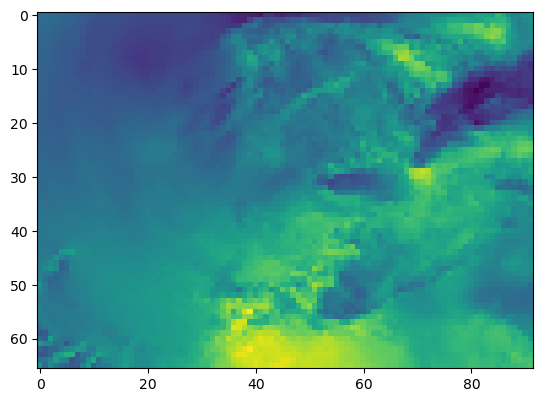

In [45]:
#Definition of your region of interest.
latbox = [27.5, 43.75]
lonbox = [-18.25, 4.5]
#latbox = [20, 80]
#lonbox = [-80, 30]

fac=4 #10 ~ 10m km, 4 ~ 25 km
lon = np.linspace(lonbox[0], lonbox[1], int((lonbox[1]-lonbox[0])*fac)+1)
lat = np.linspace(latbox[0], latbox[1], int((latbox[1]-latbox[0])*fac)+1)

zoom = 9 #10km
idx = get_nn_lon_lat_index(2**zoom, lon, lat)

#Variable selection
var = '100u'
var2='100v'
da_healpix = ds[var][0:240,:] #First day
da_healpix2 = ds[var2][0:240,:] #First day


#Regridding
da_healpix_array = da_healpix.values
da_healpix_array2 = da_healpix2.values
#da_healpix_array = da_healpix[var].values
#da_healpix_array2 = da_healpix[var2].values
da_lonlat_array = da_healpix_array[:,idx]
#da_lonlat_array = da_healpix_array2[:,idx]

#Transforming back to Data Array and adding original attributes
coords = {'time': da_healpix.time,
          'lat': lat,
          'lon': lon}
dims = ('time', 'lat', 'lon')
da_lonlat = xr.DataArray(da_lonlat_array, coords=coords, dims=dims, name=var)
da_lonlat.attrs.update(ds[var].attrs)
###da_lonlat.attrs.update(ds.attrs)
da_lonlat2 = xr.DataArray(da_lonlat_array, coords=coords, dims=dims, name=var2)
da_lonlat2.attrs.update(ds[var2].attrs)


#Too see the results (first time step)
plt.imshow(np.flip(da_lonlat[0,:,:],axis=0))

In [46]:
### compute wind

In [47]:
wnd100m = (da_lonlat**2 + da_lonlat2**2)**(1/2)
#plt.imshow(np.flip(wnd100m[0,:,:],axis=0))

In [48]:
d = np.flip(wnd100m).to_dataset(name='ws100')
#d['ws100'][0,...].plot()
d.ws100.attrs['units'] = 'm s**-1'
d = d.rename({"lon": "longitude", "lat": "latitude"})
d['ws100']    

<xarray.DataArray 'ws100' (time: 240, latitude: 66, longitude: 92)> Size: 12MB
array([[[ 4.18073   ,  4.98159835,  1.05552433, ...,  5.49652089,
          5.53967927,  6.31170703],
        [ 6.48285156,  6.98898059,  9.21656763, ...,  5.84313658,
          5.66148298,  3.62037248],
        [ 8.31220551, 11.06675629, 11.46429885, ...,  0.12146924,
          0.13525834,  3.29285438],
        ...,
        [12.99365895, 11.73027311, 13.65496391, ...,  3.13325471,
          9.16256572, 11.48266274],
        [13.90215349, 14.19738913, 13.24933994, ..., 11.90880851,
          6.34236027,  2.12775094],
        [16.72186262, 15.85775647, 16.08513636, ..., 14.25206   ,
         14.04981986, 12.51042544]],

       [[ 4.78148916,  5.66155312,  4.7598776 , ...,  4.71120575,
          4.82315857,  5.49830657],
        [ 6.15346146,  7.74858413, 10.69604205, ...,  6.01645521,
          6.14860614,  5.98859648],
        [ 7.57193691, 12.02237438, 13.50959033, ...,  5.29422142,
          5.42846554,  5.22708857],
...
        [ 4.86280223,  3.88391638,  7.28809778, ..., 13.6945752 ,
         15.76134337, 16.06336566],
        [ 6.15037834,  6.44318092,  7.65471737, ...,  5.6648898 ,
         11.17393202, 10.20789118],
        [ 7.25298305,  5.98181792,  5.62879321, ...,  3.99845331,
         11.52517104,  5.4013432 ]],

       [[ 4.11597356,  4.84346188,  6.10772168, ..., 12.31943615,
         12.17607483, 12.16165993],
        [ 4.95403363,  6.23738562,  8.15652517, ..., 12.73511602,
         12.63046776, 12.53676014],
        [ 5.78995737,  7.28774712,  8.38548033, ..., 13.15729123,
         13.03116628, 13.06533152],
        ...,
        [ 5.10403595,  4.27501216,  7.0096022 , ..., 13.3440483 ,
         16.38138352, 17.75692179],
        [ 6.73330769,  7.21753384,  8.01716678, ...,  6.71115665,
         10.60409583, 10.44357366],
        [ 7.54100585,  6.44862427,  5.91487928, ...,  5.41727942,
         12.73304982,  2.65867176]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2020-01-29T23:00:00 ... 2020-01-20
  * latitude   (latitude) float64 528B 43.75 43.5 43.25 43.0 ... 28.0 27.75 27.5
  * longitude  (longitude) float64 736B 4.5 4.25 4.0 ... -17.75 -18.0 -18.25
Attributes:
    units:    m s**-1

In [49]:
###Conversion to wind power

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_1962150/3655203214.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cv = pd.read_csv('https://raw.githubusercontent.com/hcbloomfield19/UREAD_energy_models_demo_scripts/main/Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')


    ws      cf
0  0.0  0  0.0
1  0.5  0  0.0
2  1.0  0  0.0
3  1.5  0  0.0
4  2.0  0  0.0


Text(0, 0.5, 'Capacity factor')

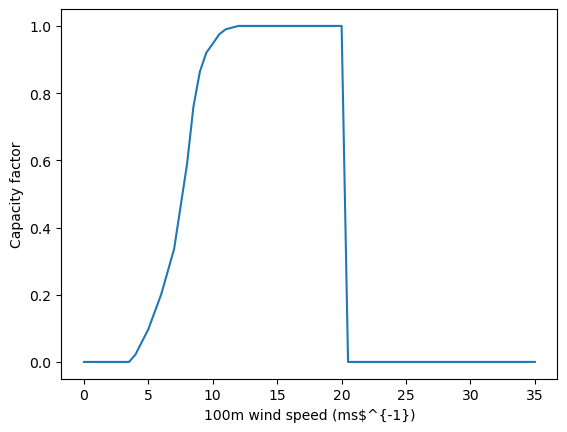

In [51]:
cv = pd.read_csv('https://raw.githubusercontent.com/hcbloomfield19/UREAD_energy_models_demo_scripts/main/Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')
print(cv.head())
plt.plot(cv['ws'],cv['cf'])
plt.xlabel('100m wind speed (ms$^{-1})')
plt.ylabel('Capacity factor')

In [52]:
def convert_to_windpower(wind_speed_data,power_curve_data):
    # convert to an array
    power_curve_w = np.array(power_curve_data['ws'])
    power_curve_p = np.array(power_curve_data['cf'])

    #interpolate to fine resolution.
    pc_winds = np.linspace(0,50,501) # make it finer resolution
    pc_power = np.interp(pc_winds,power_curve_w,power_curve_p)

    reshaped_speed = wind_speed_data.flatten()
    test = np.digitize(reshaped_speed,pc_winds,right=False) # indexing starts
    #from 1 so needs -1: 0 in the next bit to start from the lowest bin.
    test[test ==len(pc_winds)] = 500 # make sure the bins don't go off the
    #end (power is zero by then anyway)
    wind_power_flattened = 0.5*(pc_power[test-1]+pc_power[test])

    wind_power_cf = np.reshape(wind_power_flattened,(np.shape(wind_speed_data)))

    return(wind_power_cf)

In [53]:
d['cf'] = (['time', 'latitude', 'longitude'],  convert_to_windpower(d['ws100'].values, cv) )
d

<xarray.Dataset> Size: 23MB
Dimensions:    (time: 240, latitude: 66, longitude: 92)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2020-01-29T23:00:00 ... 2020-01-20
  * latitude   (latitude) float64 528B 43.75 43.5 43.25 43.0 ... 28.0 27.75 27.5
  * longitude  (longitude) float64 736B 4.5 4.25 4.0 ... -17.75 -18.0 -18.25
Data variables:
    ws100      (time, latitude, longitude) float64 12MB 4.181 4.982 ... 2.659
    cf         (time, latitude, longitude) float64 12MB 0.0334 0.09375 ... 0.0

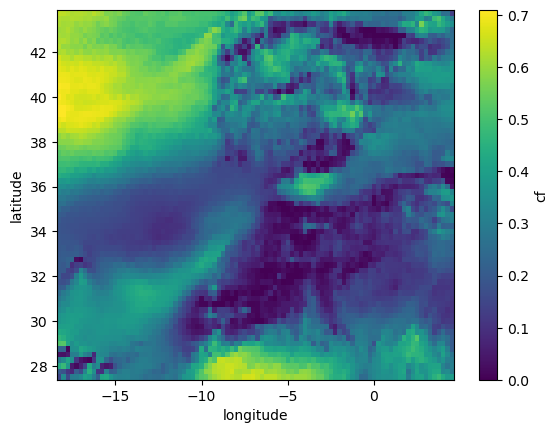

In [54]:
#d['cf'].isel(time=slice(0,48, 8)).plot(x="longitude", y="latitude", col="time", col_wrap=3, cmap=plt.cm.viridis)
d['cf'].mean(axis=0).plot()

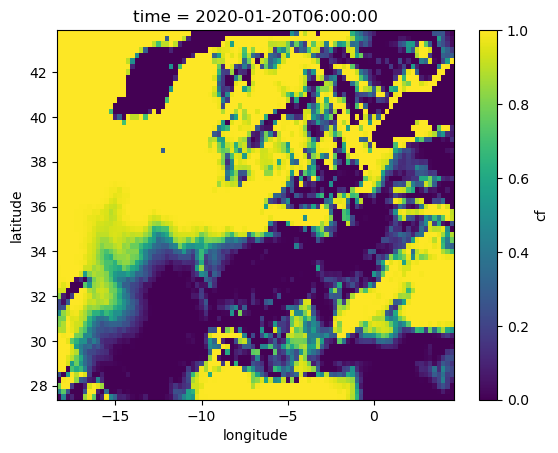

In [57]:
d['cf'].isel(time=d['cf'].mean(dim=['latitude', 'longitude']).argmax('time')).plot(x="longitude", y="latitude")


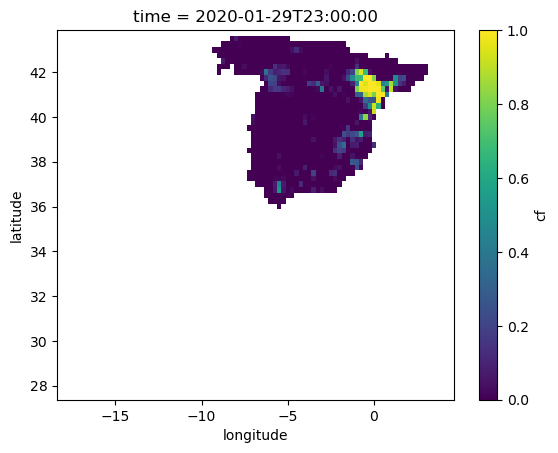

In [58]:
## how to apply a mask (country mask, weighted mask)
#%pip install regionmask
tmp =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(['Spain']))
tmp[0,...].plot()                          

In [59]:
import numpy as np
import cfgrib
import xarray as xr # xarray library access and manipulate multi-dimensional data (such as netcdf). With the cfgrib engine we can manipulate grib files
import regionmask # regionmask helps create of geographical regions.
from matplotlib import pyplot as plt # matplotlib package provides different functions to plot data

/home/b/b382006/.local/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


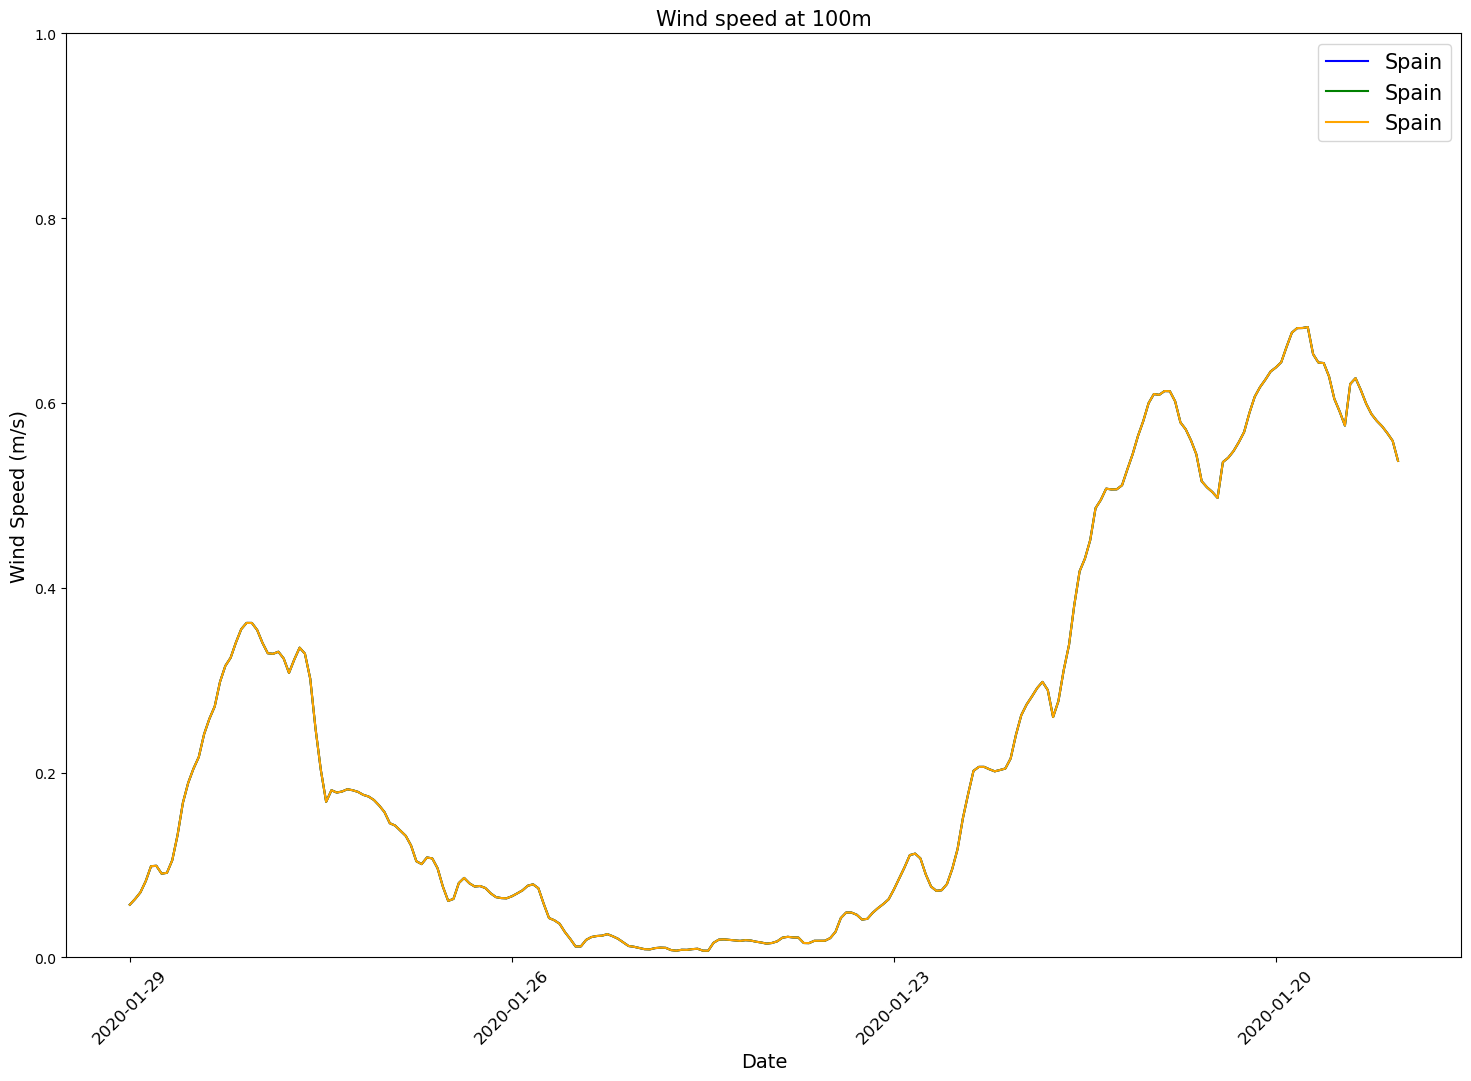

In [60]:
# create the cosine weight of latitudes
weigths = np.cos(np.deg2rad(d.latitude))
# create mask of countries based on the data latitude and longitude
countries_masked = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(d, lon_name='longitude', lat_name='latitude')

countries_name = ['Spain', 'Spain', 'Spain']
colors = ['blue', 'green', 'orange']

fig, ax = plt.subplots(figsize=(18, 12))
for ii, i in enumerate(countries_name):
    # select different countries
#    ds_country =d['ws100'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
    ds_country =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
    # applied the weighted mean over the country
    wnd100m_country = ds_country.weighted(weigths).mean(dim=('latitude', 'longitude'))
    ax.plot(wnd100m_country, color=colors[ii], label=i)
ax.set_xticks(np.arange(0, len(wnd100m_country.time), 3 * 24))
ax.set_xticklabels(wnd100m_country['time'].values[0: -1: 3 * 24].astype('datetime64[D]'), rotation=45, fontsize=12)
#ax.set_ylim([0, 18])
ax.set_ylim([0, 1])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Wind Speed (m/s)', fontsize=14)
ax.legend(fontsize=15)
plt.title('Wind speed at 100m', fontsize=15)
plt.savefig('wind_speed_100m_countries.png')

## Work with atlite tool

### Install atlite

In [ ]:
#%pip install cartopy
#%pip install intake
#%pip install aiohttp

In [61]:
#%pip install git+https://github.com/pypsa/atlite_gems.git 